<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/day9_pm_afternoon/D9_A_Dyna_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Dyna-Q algorithm is a model-based reinforcement learning algorithm. It combines direct learning from real experience with indirect learning from simulated experience using a learned model. It's especially useful when the environment is deterministic.

### Environment: The Maze

For this demonstration, we'll use a simple gridworld environment that is often described as a maze.

#### State space:
The state space consists of each cell in the maze. If the maze is of size $ m \times n $, then there are $ m \times n $ states.

#### Action space:
At each state (or cell), an agent can choose one of the following actions:
1. UP
2. DOWN
3. LEFT
4. RIGHT

#### Rewards:
- For each step that doesn't lead to the goal, the agent receives a reward of -1.
- If the agent hits a wall (tries to move outside the maze or into a barrier), it stays in its current location and receives a reward of -10.
- Upon reaching the goal state, the agent receives a reward of +100.

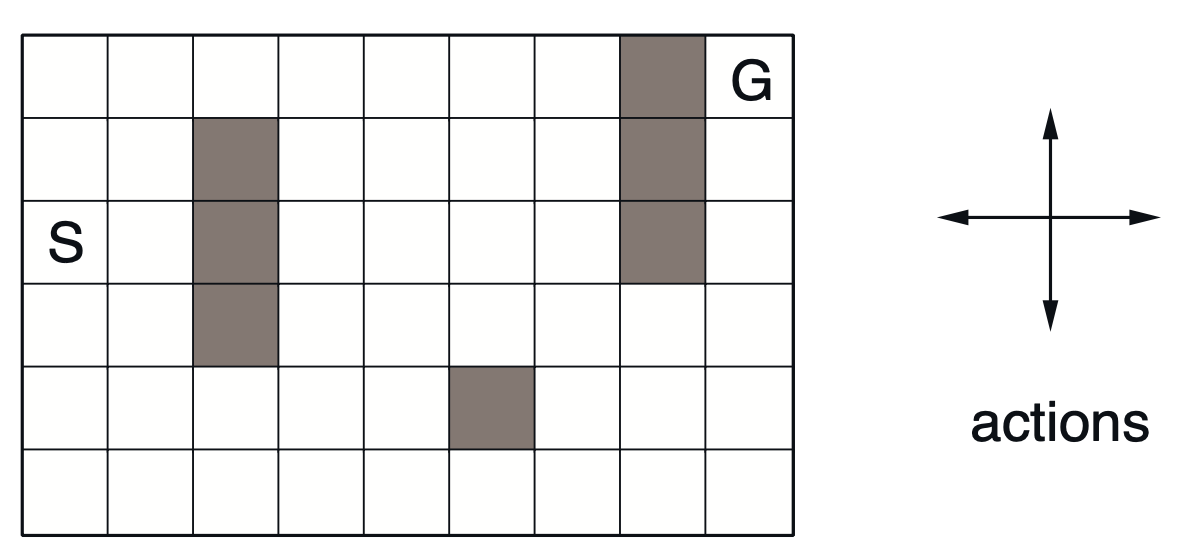

### Dyna-Q Algorithm:

Pseudo-code for the Dyna-Q algorithm:

```
Initialize Q(s, a) arbitrarily, for all s, a
Initialize the model for all s, a as a blank slate
Repeat (for each episode):
    Initialize s
    While s is not the terminal state:
        Choose a from s using policy derived from Q (e.g., ε-greedy)
        Take action a, observe reward r and next state s'
        Q(s, a) = Q(s, a) + α [r + γ max_a Q(s', a) - Q(s, a)]
        Update the model with: Model(s, a) = (r, s')
        s = s'
        Repeat n times:
            Randomly choose previously observed state s and action a
            Retrieve r, s' from Model(s, a)
            Q(s, a) = Q(s, a) + α [r + γ max_a Q(s', a) - Q(s, a)]
```

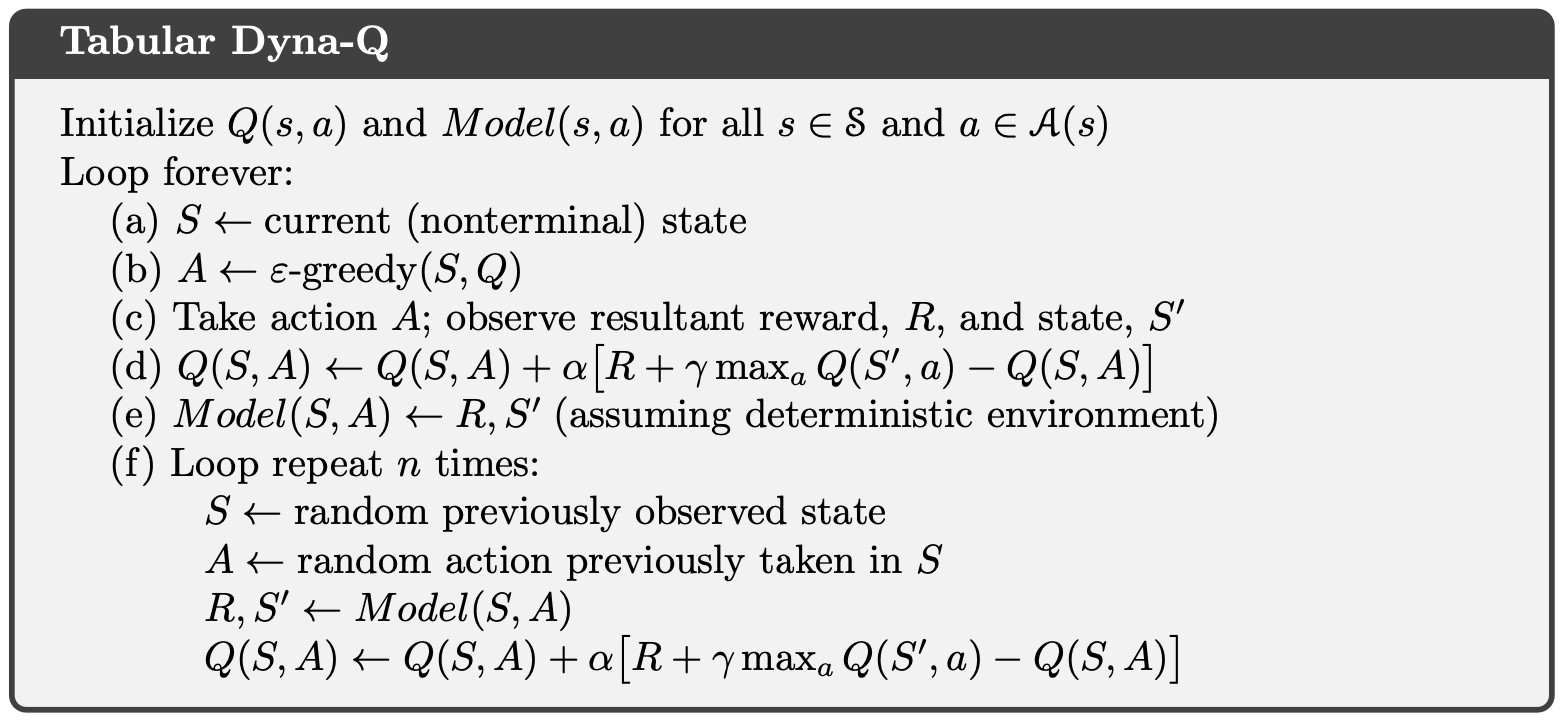

### Implementation Dyna-Q in Maze environment:

#### Step 1.1: Create the Maze Environment

```python
import numpy as np

class Maze:
    def __init__(self, size=(5, 5), start=(0, 0), goal=(4, 4), walls=[]):
        self.size = size
        self.start = start
        self.goal = goal
        self.walls = walls
        self.current_position = start
        
    def reset(self):
        self.current_position = self.start
        return self.current_position

    def step(self, action):
        x, y = self.current_position
        
        if action == "UP":
            x -= 1
        elif action == "DOWN":
            x += 1
        elif action == "LEFT":
            y -= 1
        elif action == "RIGHT":
            y += 1
        
        # Check for walls or maze boundaries
        if (x, y) in self.walls or x < 0 or y < 0 or x >= self.size[0] or y >= self.size[1]:
            x, y = self.current_position
            reward = -10
        elif (x, y) == self.goal:
            reward = 100
        else:
            reward = -1
        
        self.current_position = (x, y)
        return self.current_position, reward
```
#### 1.2: Create and Visualize a Maze environment with walls

```python
walls = [(0, 1), (1, 1), (2, 1), (3, 1), (5, 1), (6, 1), (7, 1), (4, 1)]

maze = Maze(size=(9,6), walls=walls, goal=(8,5))
```

```python
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_maze(maze):
    fig, ax = plt.subplots()
    
    for i in range(maze.size[0]):
        for j in range(maze.size[1]):
            if (i, j) in maze.walls:
                ax.add_patch(patches.Rectangle((i, j), 1, 1, color="gray"))
            else:
                ax.add_patch(patches.Rectangle((i, j), 1, 1, color="white"))
            
            if (i, j) == maze.start:
                ax.text(i + 0.5, j + 0.5, 'S', ha='center', va='center', color="blue", fontsize=15)
            elif (i, j) == maze.goal:
                ax.text(i + 0.5, j + 0.5, 'G', ha='center', va='center', color="red", fontsize=15)

    ax.set_xlim(0, maze.size[0])
    ax.set_ylim(0, maze.size[1])
    ax.set_xticks(range(maze.size[0]))
    ax.set_yticks(range(maze.size[1]))
    ax.grid(which='both')
    plt.show()

visualize_maze(maze)

```

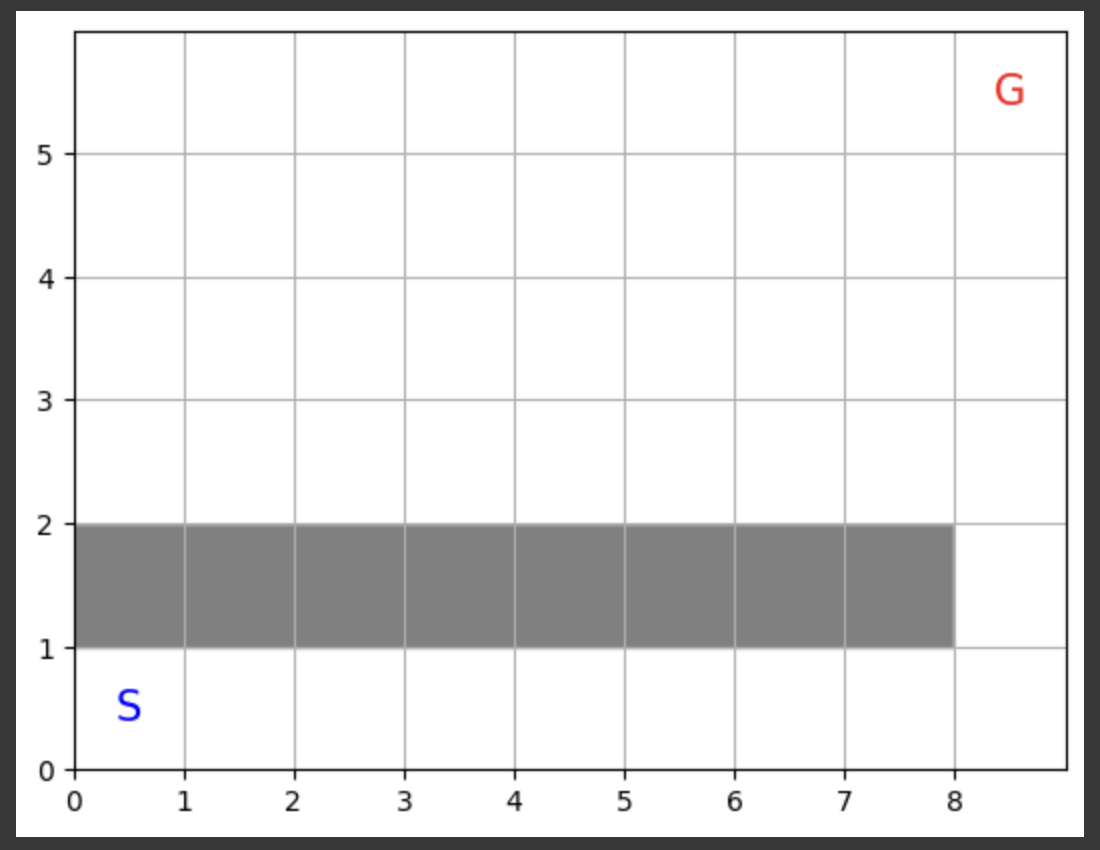

#### Step 2: Dyna-Q Implementation

```python


from collections import defaultdict
import random

class DynaQ:
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.1, planning_n=5):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_n = planning_n
        
        self.Q = defaultdict(float)
        self.model = defaultdict(tuple)

    def choose_action(self, state, actions):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(actions)
        else:
            q_values = [self.Q[(state, a)] for a in actions]
            max_q = max(q_values)
            return actions[q_values.index(max_q)]
        
    def learn(self, state, action, reward, next_state, next_actions):
        max_next_q = max([self.Q[(next_state, a)] for a in next_actions])
        self.Q[(state, action)] += self.alpha * (reward + self.gamma * max_next_q - self.Q[(state, action)])
        
        # Update the model
        self.model[(state, action)] = (reward, next_state)

        # Plan using the model
        for _ in range(self.planning_n):
            state_sample, action_sample = random.choice(list(self.model.keys()))
            reward_sample, next_state_sample = self.model[(state_sample, action_sample)]
            max_next_q = max([self.Q[(next_state_sample, a)] for a in next_actions])
            self.Q[(state_sample, action_sample)] += self.alpha * (reward_sample + self.gamma * max_next_q - self.Q[(state_sample, action_sample)])
```

#### Step 3: Training the Agent

```python
# Initialize Dyna-Q agent
walls = [(2, 1), (2, 2), (2, 3), (1, 2), (3, 2)]
maze = Maze(walls=walls)
agent = DynaQ()

actions = ["UP", "DOWN", "LEFT", "RIGHT"]
num_episodes = 100
rewards_per_episode = []
steps_per_episode = []

for episode in range(num_episodes):
    state = maze.reset()
    total_reward = 0
    steps = 0

    while state != maze.goal:

        action = agent.choose_action(state, actions)
        next_state, reward = maze.step(action)
        agent.learn(state, action, reward, next_state, actions)

        total_reward += reward
        state = next_state
        steps += 1

    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)
```

#### Step 4: Plotting Rewards and Steps per Episode

To plot in Google Colab, use the following:
```python
plt.plot(steps_per_episode)
plt.ylabel('Steps per Episode')
plt.xlabel('Episode')
plt.title('Training Rewards Over Time')
plt.show()
```

```python
plt.plot(rewards_per_episode)
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.title('Training Rewards Over Time')
plt.show()
```

#### Step 5: Visualizing the Learned Policy


```python
def visualize_maze_with_policy(maze, agent, actions):
    fig, ax = plt.subplots()

    arrow_map = {
        'UP': '↑',
        'DOWN': '↓',
        'LEFT': '←',
        'RIGHT': '→'
    }

    for i in range(maze.size[0]):
        for j in range(maze.size[1]):
            if (i, j) in maze.walls:
                ax.add_patch(patches.Rectangle((i, j), 1, 1, color="gray"))
            else:
                ax.add_patch(patches.Rectangle((i, j), 1, 1, color="white"))
                q_values = [agent.Q[((i, j), a)] for a in actions]
                best_action = actions[q_values.index(max(q_values))]
                ax.text(i + 0.5, j + 0.5, arrow_map[best_action], ha='center', va='center', color="green", fontsize=16)

            if (i, j) == maze.start:
                ax.text(i + 0.5, j + 0.5, 'S', ha='left', va='bottom', color="blue", fontsize=15, alpha=0.5)
            elif (i, j) == maze.goal:
                ax.text(i + 0.5, j + 0.5, 'G', ha='left', va='bottom', color="red", fontsize=15, alpha=0.5)

    ax.set_xlim(0, maze.size[0])
    ax.set_ylim(0, maze.size[1])
    ax.set_xticks(range(maze.size[0]))
    ax.set_yticks(range(maze.size[1]))
    ax.grid(which='both')
    plt.show()

visualize_maze_with_policy(maze, agent, actions)
```

### Exercise 1:

Run Dyna-Q with `planning_n=0`, `planning_n=10` and `planning_n=50` and plot the steps per episode in one plot to compare.

Dyna-Q+ is an extension to the Dyna-Q algorithm to encourage exploration of state-action pairs that haven't been visited for a long time. Dyna-Q+ introduces a bonus reward to incentivize exploration of such state-action pairs.

The key modification in Dyna-Q+ as compared to Dyna-Q is in the reward calculation during the planning phase. Specifically, in Dyna-Q+, the reward for a simulated state-action transition is augmented by a bonus which is a function of the time since the last real experience of that state-action pair.

The bonus reward is calculated as:
\[ \kappa \sqrt{\tau(s,a)} \]
Where:
- \( \kappa \) is a small constant value.
- \( \tau(s,a) \) is the time since the last real experience of state-action pair \( (s,a) \).

To implement Dyna-Q+, you need to maintain a counter for each state-action pair that keeps track of the number of time-steps since that state-action was last tried in the real environment.

Here's the step-by-step approach to implement Dyna-Q+:

1. **Initialization**:
   - Initialize the Q-values.
   - Initialize the model for each state-action pair.
   - Initialize \( \tau(s,a) \) for all state-action pairs to zero.

2. **Loop for each episode**:
   - While the goal is not reached:
     - Increase \( \tau(s,a) \) for all state-action pairs by 1.
     - Select an action using an exploration policy (like epsilon-greedy) based on the current Q-values.
     - Execute the action, observe the reward and next state.
     - Update the Q-value for the state-action pair.
     - Store the experienced transition in the model.
     - Set \( \tau(s,a) \) for the experienced state-action pair to zero.
     - **Planning**: Repeat for a number of planning steps:
       - Sample a state and action from the set of all experienced state-action pairs.
       - Query the model to get the simulated next state and reward.
       - Add bonus to the reward: \( \kappa \sqrt{\tau(s,a)} \).
       - Update the Q-value for the sampled state-action pair with the simulated reward and next state.

Now, let's modify the `DynaQAgent` class to implement Dyna-Q+:

```python
class DynaQPlusAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.95, epsilon=0.1, planning_steps=10, kappa=0.001):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.planning_steps = planning_steps
        self.kappa = kappa

        self.Q = defaultdict(float)
        self.Model = defaultdict(tuple)
        
        # Time since last visit initialization
        self.tau = defaultdict(int)
        
        self.actions = actions

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.actions)
        else:
            q_values = [self.Q[(state, a)] for a in self.actions]
            return self.actions[np.argmax(q_values)]

    def learn(self, state, action, reward, next_state):
        max_q_next = max([self.Q[(next_state, a)] for a in self.actions])
        self.Q[(state, action)] += self.alpha * (reward + self.gamma * max_q_next - self.Q[(state, action)])
        
        # Update the model with the new experience
        self.Model[(state, action)] = (reward, next_state)
        
        # Reset the time since the last visit for the current state-action
        self.tau[(state, action)] = 0
        
        # Increment the time since last visit for all state-action pairs
        for state_action in self.tau.keys():
            self.tau[state_action] += 1

        # Planning phase
        for _ in range(self.planning_steps):
            # Randomly sample a state-action from the model's keys
            state_sample, action_sample = random.choice(list(self.Model.keys()))
            reward_sample, next_state_sample = self.Model[(state_sample, action_sample)]
            
            # Add exploration bonus
            reward_sample += self.kappa * np.sqrt(self.tau[(state_sample, action_sample)])
            
            max_q_sample_next = max([self.Q[(next_state_sample, a)] for a in self.actions])
            self.Q[(state_sample, action_sample)] += self.alpha * (reward_sample + self.gamma * max_q_sample_next - self.Q[(state_sample, action_sample)])
```

Note the changes made:
1. We've added `self.kappa` which is the constant for the exploration bonus.
2. We've added `self.tau` which keeps track of the number of time-steps since each state-action pair was last tried.
3. During the learning phase, after updating the

 Q-values with the real experience, we update `self.tau` for all state-action pairs and reset the counter for the current state-action to zero.
4. During the planning phase, when we sample a simulated experience from the model, we add the exploration bonus to the reward before updating the Q-values.

This agent should now exhibit more exploration, especially for state-action pairs that haven't been explored recently.